In [3]:
from __future__ import print_function, division

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import simplejson as json
import shapely
import pandas as pd
import geopandas as gpd

from collections import defaultdict

In [5]:
def filter_HI(x, y):
    """Only keep main Hawaii islands, drop tail far west"""
    return zip(*filter(lambda x: x[0]> -161, zip(x,y)))
def mod_long(x, y, z=None):
    """Some Aleutian archipelago islands cross the -180 longitude point. Mod longitude to bring them close to the rest."""
    return (np.mod(x,-360), y)

In [6]:
def col_alpha_rescale(percentD, percentR, scale=0.4):
    """ Return RGBA color according to D, R vote percents, namely blue if D>R and red otherwise, 
    with transparency A set by vote difference fully opaque colors at and above input parameter scale (default=0.4)"""
    red, blue = (0., 1.) if percentD > percentR else (1.,0.)
    alpha = min(max(0.2 + 0.8*(np.abs(percentD-percentR)/(scale)),0),1)
    return  (red, 0, blue,alpha)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'nyt_cmap', [(x, col_alpha_rescale(x,(1-x))) for x in np.linspace(0,1,100)])

In [7]:
def func_add_legend(fig, left=1.05, width=0.015, height=0.7, voffset=0):
    """Add red/blue bar legend to a figure, with offset position given as input"""
    cax = fig.add_axes([left, (1.-height)/2, width, height])
    for cc in np.arange(0.8,0.49,-0.1):
        cax.fill((0,0,1,1),(cc,cc+0.1,cc+0.1,cc),facecolor = col_alpha_rescale((1-cc)/2,cc/2) )
        cax.plot((0,1),(cc,cc),lw=1,c='w' )
    for cc in np.arange(0.2,0.51,0.1):
        cax.fill((0,0,1,1),(cc-0.1,cc,cc,cc-0.1),facecolor = col_alpha_rescale((1-cc)/2+0.01,cc/2) )
        cax.plot((0,1),(cc,cc),lw=1,c='w' )
    ax2=cax.twiny()    
    cax.yaxis.tick_right()
    cax.set_yticks(np.arange(0.2,0.81,0.1))
    cax.set_yticklabels(map(str,range(30,1,-10)+range(0,31,10)))
    for ax in [cax,ax2]:
        ax.set_xticks([])
    cax.set_ylim([0.15,0.85])
    cax.set_xlabel('D margin (%)')
    ax2.set_xlabel('R margin (%)')
    return fig

### import state borders

In [8]:
us_df = gpd.read_file(os.path.join(os.path.pardir, 'input','cb_2017_us_state_20m.shp'))
us_df = us_df.sort_values('NAME')
us_df = us_df.reset_index(drop=True )
us_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"POLYGON ((-88.46866248405129 31.8938557116156,..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,05,00068085,0400000US05,05,AR,Arkansas,00,134768100673,2963631791,"POLYGON ((-94.617919 36.499414, -94.3612029999..."
4,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."


To move Hawaii/Alaska closer to the mainland, we use [`shapely.ops`, `shapely.affinity`](https://shapely.readthedocs.io/en/stable/manual.html)

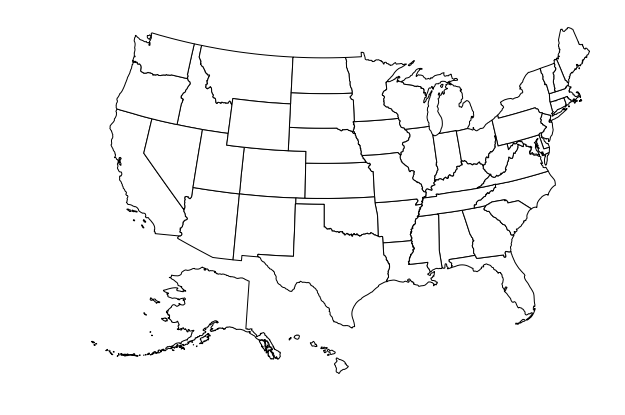

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
rest = us_df[~us_df['STUSPS'].isin(['HI','AK','PR'])]
# rest.plot(ax=ax)

# move hawaii
temp = us_df[us_df['STUSPS'].isin(['HI'])].copy()
temp.loc[:,'geometry'] = temp.loc[:,'geometry'].apply(lambda x: shapely.ops.transform(filter_HI, x))
temp.loc[:,'geometry'] = temp.loc[:,'geometry'].apply(lambda x: shapely.affinity.translate(x, xoff=57, yoff=3))
# temp.plot(ax=ax)
tempHI = temp.copy()

# move alaska
temp = us_df[us_df['STUSPS'].isin(['AK'])].copy()
temp.loc[:,'geometry'] = temp.loc[:,'geometry'].apply(lambda x: shapely.ops.transform(mod_long, x))
temp.loc[:,'geometry'] = temp.loc[:,'geometry'].apply(lambda x: shapely.affinity.affine_transform(x, matrix=[0.3,0,0,0.44,-65,-1]))
# temp.plot(ax=ax)

us_df = gpd.GeoDataFrame(pd.concat([rest, tempHI, temp], ignore_index=True), crs=rest.crs)
us_df.to_crs(epsg=2163).plot(ax=ax, edgecolor='k', facecolor='w')
ax.set_axis_off()

## midterms election results

The New York Times interactive election results page is taking its data from a JSON file that can be downloaded at https://int.nyt.com/applications/elections/2018/api/1/races/2018-11-06.json

In [10]:
with open(os.path.join(os.path.pardir, 'input',"usa_midterms_2018-11-06.json")) as json_data:
    data = json.load(json_data)

In [583]:
# data['races'][0]

In [11]:
print(data.keys())
print(data['races'][0].keys())
data['races'][0]['candidates'][0]

['dates', 'cache', 'generated', 'races', 'load_time', 'data_load_time']
['rating', 'seat_name', 'office', 'reporting_display', 'seat', 'uncontested', 'result', 'race_text', 'poll_time', 'precincts_reporting', 'race_slug', 'poll_display', 'candidates', 'race_id', 'precincts_total', 'race_call_note', 'race_name', 'election_date', 'votes', 'lost_seat', 'party_id', 'gain', 'report', 'incumbent_party', 'counties', 'state_slug', 'nyt_measure_title', 'nyt_title', 'has_incumbent', 'url', 'result_source', 'race_type', 'nyt_rating', 'runoff', 'state_id', 'no_forecast', 'election_type']


{'candidate_id': 'young-513',
 'candidate_key': 'youngd',
 'electoral_votes': 0,
 'first_name': 'Don',
 'incumbent': True,
 'last_name': 'Young',
 'name_display': 'Don Young',
 'order': 1,
 'party_id': 'republican',
 'percent': 53.3,
 'percent_display': '53.3',
 'runoff': False,
 'votes': 149779,
 'winner': True}

In [12]:
missing_votes = {}
for row in data['races']:
    if row['office'] != 'U.S. House':
        continue
    if row['precincts_reporting']==0:
        print('Data missing from record', data['races'].index(row), row['state_id'], row['seat_name'] )
        
        cd116fp = '00' if 'large' in row['seat_name'].lower() else "{:02d}".format(row['seat'])
        state = row['state_id']
        fips = state + cd116fp

        missing_votes[data['races'].index(row)] = fips

        assert row['uncontested']
        assert len(row['candidates'])==1
        assert row['counties']==[]

Data missing from record 9 AL District 7
Data missing from record 118 FL District 10
Data missing from record 122 FL District 14
Data missing from record 128 FL District 20
Data missing from record 129 FL District 21
Data missing from record 132 FL District 24
Data missing from record 144 GA District 5
Data missing from record 147 GA District 8
Data missing from record 219 MA District 1
Data missing from record 222 MA District 4
Data missing from record 225 MA District 7
Data missing from record 226 MA District 8
Data missing from record 301 NC District 3
Data missing from record 359 NY District 5
Data missing from record 370 NY District 16
Data missing from record 434 PA District 18
Data missing from record 511 VA District 3
Data missing from record 539 WI District 2


The NYT did not update their vote counts for uncontested races. This also results in having no county totals for all of those counties within the district.

E.g. see NC 3rd, where the Republican candidate won 173,483 votes according to [Ballotpedia](https://ballotpedia.org/North_Carolina%27s_3rd_Congressional_District_election,_2018):

In [13]:
data['races'][301]['candidates'], data['races'][301]['precincts_reporting']

([{'candidate_id': 'jones-1362',
   'candidate_key': 'jonesw',
   'electoral_votes': 0,
   'first_name': 'Walter B.',
   'incumbent': True,
   'last_name': u'Jones\ufeff',
   'name_display': u'Walter B. Jones\ufeff',
   'order': 1,
   'party_id': 'republican',
   'percent': 0,
   'percent_display': '0.0',
   'runoff': False,
   'votes': 0,
   'winner': True}],
 0)

### fix missing values

I picked the vote totals for each uncontested race from [Ballotpedia](https://ballotpedia.org/), and merged them with the data dictionary defined above.

***NOTE: for four races in Florida, the vote counts are not there even on the florida official election results page. For those, I arbitrarily gave 200,000 votes to the candidate (which is on the lower end of a typical district vote totals).***

In [14]:
missing_votes

{9: 'AL07',
 118: 'FL10',
 122: 'FL14',
 128: 'FL20',
 129: 'FL21',
 132: 'FL24',
 144: 'GA05',
 147: 'GA08',
 219: 'MA01',
 222: 'MA04',
 225: 'MA07',
 226: 'MA08',
 301: 'NC03',
 359: 'NY05',
 370: 'NY16',
 434: 'PA18',
 511: 'VA03',
 539: 'WI02'}

In [15]:
results_manual = {9: (185010, 'https://ballotpedia.org/Alabama%27s_7th_Congressional_District_election,_2018'),
                  118:(2*10**5,'no results anywhere'),
                  122:(2*10**5,'no results anywhere'),
                  128:(202659,'https://ballotpedia.org/Florida%27s_20th_Congressional_District_election,_2018'),
                  129:(2*10**5,'no results anywhere'),
                  132:(2*10**5,'no results anywhere'),
                  144:(275406,'https://ballotpedia.org/Georgia%27s_5th_Congressional_District_election,_2018'),
                  147:(198152,'https://ballotpedia.org/Georgia%27s_8th_Congressional_District_election,_2018'),
                  219:(211790,'https://ballotpedia.org/Massachusetts%27_1st_Congressional_District_election,_2018'),
                  222:(245289,'https://ballotpedia.org/Massachusetts%27_4th_Congressional_District_election,_2018'),
                  225:(216559,'https://ballotpedia.org/Massachusetts%27_7th_Congressional_District_election,_2018'),
                  226:(259159,'https://ballotpedia.org/Massachusetts%27_8th_Congressional_District_election,_2018'),
                  301:(173483,'https://ballotpedia.org/North_Carolina%27s_3rd_Congressional_District_election,_2018'),
                  359:(160500,'https://ballotpedia.org/New_York%27s_5th_Congressional_District_election,_2018'),
                  370:(182044,'https://ballotpedia.org/New_York%27s_16th_Congressional_District_election,_2018'),
                  434:(231472,'https://ballotpedia.org/Pennsylvania%27s_18th_Congressional_District_election,_2018'),
                  511:(309116,'https://ballotpedia.org/Wisconsin%27s_2nd_Congressional_District_election,_2018'),
                  539:(198615,'https://ballotpedia.org/Virginia%27s_3rd_Congressional_District_election,_2018'),
                 }

In [16]:
for idx in results_manual:
    data['races'][idx]['candidates'][0]['votes'] = results_manual[idx][0]

## Load congressional district maps
https://catalog.data.gov/dataset/tiger-line-shapefile-2018-nation-u-s-116th-congressional-district-national

In [21]:
cd = gpd.GeoDataFrame.from_file(os.path.join(os.path.pardir, 'input',"tl_2018_us_cd116/tl_2018_us_cd116.dbf"))
# drop useless columns
cd.drop(columns = [ u'LSAD', u'CDSESSN', u'MTFCC', u'FUNCSTAT', u'ALAND', u'AWATER', u'INTPTLAT', u'INTPTLON'], inplace=True)

In [22]:
cd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 5 columns):
STATEFP     444 non-null object
CD116FP     444 non-null object
GEOID       444 non-null object
NAMELSAD    444 non-null object
geometry    444 non-null object
dtypes: object(5)
memory usage: 17.4+ KB


In [23]:
cd = pd.merge(cd, us_df[['GEOID','STUSPS']], left_on='STATEFP', right_on='GEOID', how='left',suffixes=['','_y'])
cd.drop(columns=['GEOID_y'], inplace=True)
cd.head()

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS
0,27,07,2707,Congressional District 7,"POLYGON ((-97.239093 48.96826, -97.239092 48.9...",MN
1,27,02,2702,Congressional District 2,POLYGON ((-93.91130699999999 44.54651399999999...,MN
2,27,06,2706,Congressional District 6,"POLYGON ((-94.640411 45.370723, -94.64039 45.3...",MN
3,27,08,2708,Congressional District 8,"POLYGON ((-95.183216 47.412773, -95.165981 47....",MN
4,17,01,1701,Congressional District 1,"POLYGON ((-88.136771 41.422851, -88.136331 41....",IL


Note that 7 states have only 1 representative (code 00 in the `CD116FP` column), while others like DC and Puerto Rico (and other US territories) have non-voting delegates (code 98). Finally there are ZZ codes that seem to be placeholders.

In [24]:
cd[cd['CD116FP'].isin(['00','98','ZZ'])].sort_values('CD116FP')

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS
192,38,00,3800,Congressional District (at Large),"POLYGON ((-104.048967 48.86953399999999, -104....",ND
193,56,00,5600,Congressional District (at Large),"POLYGON ((-111.054556 44.999735, -111.054556 4...",WY
264,50,00,5000,Congressional District (at Large),"POLYGON ((-73.43770599999999 44.046104, -73.43...",VT
269,46,00,4600,Congressional District (at Large),"POLYGON ((-104.057879 44.997605, -104.050783 4...",SD
284,02,00,0200,Congressional District (at Large),"(POLYGON ((179.388742 51.941917, 179.404562 51...",AK
315,10,00,1000,Congressional District (at Large),"POLYGON ((-75.789023 39.65979, -75.788922 39.6...",DE
416,30,00,3000,Congressional District (at Large),"POLYGON ((-116.049116 48.000828, -116.049118 4...",MT
194,69,98,6998,Delegate District (at Large),"(POLYGON ((146.001994 16.028784, 146.014254 16...",NaN
263,11,98,1198,Delegate District (at Large),POLYGON ((-77.11975099999999 38.93434999999999...,DC
270,66,98,6698,Delegate District (at Large),"POLYGON ((144.563426 13.448065, 144.563574 13....",NaN


In [25]:
cd = cd[~cd['CD116FP'].isin(['98','ZZ'])]

In [26]:
cd['FIPS'] = cd['STUSPS']+cd['CD116FP']
cd.head()

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS,FIPS
0,27,07,2707,Congressional District 7,"POLYGON ((-97.239093 48.96826, -97.239092 48.9...",MN,MN07
1,27,02,2702,Congressional District 2,POLYGON ((-93.91130699999999 44.54651399999999...,MN,MN02
2,27,06,2706,Congressional District 6,"POLYGON ((-94.640411 45.370723, -94.64039 45.3...",MN,MN06
3,27,08,2708,Congressional District 8,"POLYGON ((-95.183216 47.412773, -95.165981 47....",MN,MN08
4,17,01,1701,Congressional District 1,"POLYGON ((-88.136771 41.422851, -88.136331 41....",IL,IL01


No handlers could be found for logger "shapely.geos"


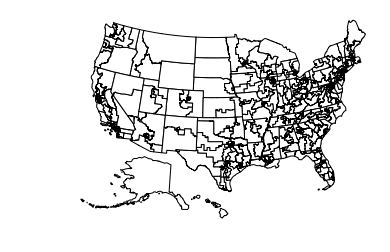

In [27]:
rest = cd[~cd['STUSPS'].isin(['HI','AK'])]

temp = cd[cd['STUSPS'].isin(['HI'])].copy()
temp.geometry = temp.geometry.apply(lambda x: shapely.ops.transform(filter_HI, x))
temp.geometry = temp.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=57, yoff=3))
# temp.plot(ax=ax)
tempHI = temp.copy()

# move alaska
temp = cd[cd['STUSPS'].isin(['AK'])].copy()
temp.geometry = temp.geometry.apply(lambda x: shapely.ops.transform(mod_long, x))
temp.geometry = temp.geometry.apply(lambda x: shapely.affinity.affine_transform(x, matrix=[0.3,0,0,0.44,-65,-1]))
# temp.plot(ax=ax)

cd_shifted = gpd.GeoDataFrame(pd.concat([rest, tempHI, temp], ignore_index=True), crs=rest.crs)
cd_shifted.to_crs(epsg=2163).plot(edgecolor='k', facecolor='w')
plt.gca().set_axis_off()

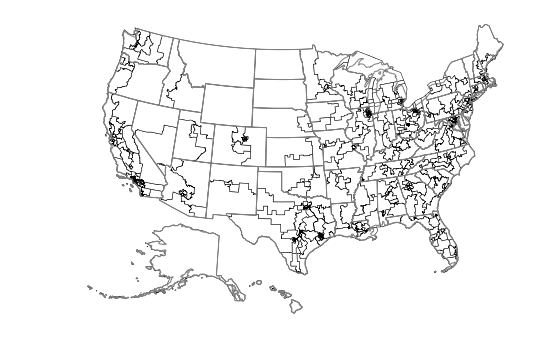

In [145]:
cd_shifted.plot(edgecolor='k',lw=0.5, facecolor='w', figsize=(10,5))
us_df.plot(edgecolor='0.5', facecolor=(0,0,0,0), ax=plt.gca())
plt.gca().set_axis_off()
plt.gcf().tight_layout()
plt.savefig('figs/districts_shifted.png', bbox_inches='tight')

Need to map the NYT JSON results to these congressional districts. In the JSON I have the state 2-letter abbreviation via the `state_id` key (`STUSPS` column above), and the congressional district number via the `seat_name` key (`CD116FP` above).

In [28]:
cd_votes = defaultdict(dict)
for row in data['races']:
    if row['office'] != 'U.S. House':
        continue
    
    cd116fp = '00' if 'large' in row['seat_name'].lower() else "{:02d}".format(row['seat'])
    state = row['state_id']
    fips = state + cd116fp
    for c in row['candidates']:
        cd_votes[fips][c['party_id']] = c['votes']

Build votes dataframe, cluster together all non-traditional parties into "independent"

In [29]:
cddf = pd.DataFrame.from_dict(cd_votes, orient='index').fillna(value=0).astype(int)
cddf['FIPS'] = cddf.index
cddf.head()

,libertarian,republican,democrat,no-party-affiliation,other,green,american-party,constitution,independent,pacific-green,...,liberty-union,reform,working-families,conservative,nonpartisan,independence,womens-equality,independent-american,united-utah,FIPS
AK00,0,149779,0,0,0,0,0,0,131199,0,...,0,0,0,0,0,0,0,0,0,AK00
AL01,0,153228,89226,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AL01
AL02,0,138879,86931,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AL02
AL03,0,147770,83996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AL03
AL04,0,184255,46492,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AL04


In [30]:
keep_columns = ['FIPS', u'green', u'libertarian', u'republican', u'democrat']

indep = sum([cddf[c] for c in cddf.columns if c not in keep_columns])
cddf = cddf[keep_columns]
cddf['independent'] = indep

cddf['total'] = cddf[[u'independent', u'green', u'libertarian', u'republican', u'democrat']].T.sum()
cddf['margin'] = (cddf['democrat'] - cddf['republican'])/(cddf['total']+1)
cddf.head()

,FIPS,green,libertarian,republican,democrat,independent,total,margin
AK00,AK00,0,0,149779,0,131199,280978,-0.533061
AL01,AL01,0,0,153228,89226,0,242454,-0.263975
AL02,AL02,0,0,138879,86931,0,225810,-0.230051
AL03,AL03,0,0,147770,83996,0,231766,-0.275164
AL04,AL04,0,0,184255,46492,0,230747,-0.597028


In [31]:
cddf.isna().sum()

FIPS           0
green          0
libertarian    0
republican     0
democrat       0
independent    0
total          0
margin         0
dtype: int64

Histograms of congressional districts by vote margin: because house districts are based on population (from the Census), the distributions are similar (this will not be true for counties, see below)

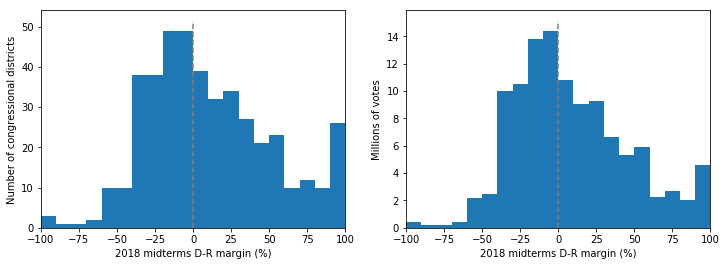

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
(100*cddf['margin']).hist(bins=np.linspace(-100,100,21), ax=ax1)
(100*cddf['margin']).hist(bins=np.linspace(-100,100,21), weights= cddf['total']/10**6, ax=ax2)
ax1.set(ylabel='Number of congressional districts')
ax2.set(ylabel = 'Millions of votes')
for ax in (ax1, ax2):
    ax.grid()
    ax.set(xlabel='2018 midterms D-R margin (%)', xlim=(-100,100))
    ax.vlines(0,0,ax.get_ylim()[1], colors='gray',linestyles='--')

In [33]:
dd = pd.merge(cd_shifted, cddf, on='FIPS')
# after fixing the uncontested races, nothing should be missing!
missing = dd[dd['total']==0]
missing

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS,FIPS,green,libertarian,republican,democrat,independent,total,margin


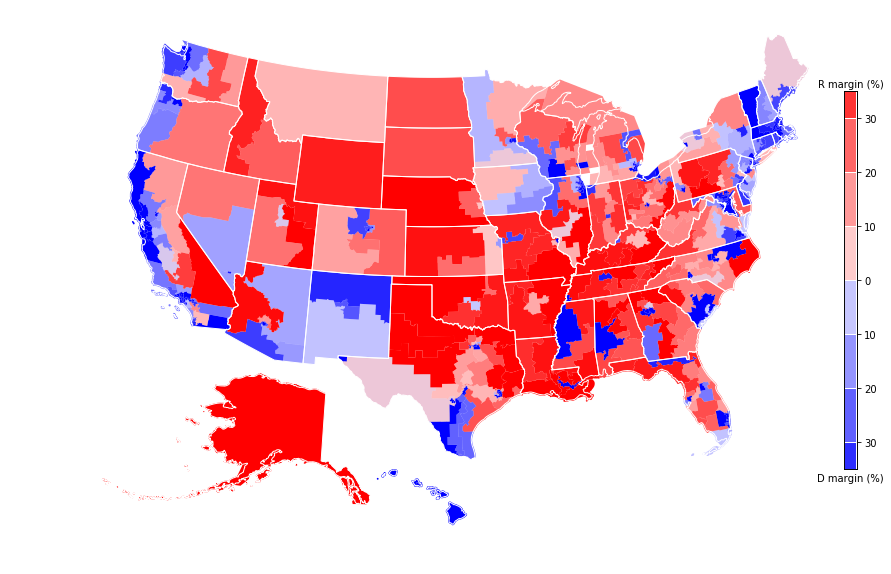

In [34]:
dd.to_crs(epsg=2163).plot(column='margin', cmap=cmap, figsize=(12,7.5), vmin=-1, vmax=1)
# missing.to_crs(epsg=2163).plot(facecolor='k', ax=plt.gca())
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='w', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
func_add_legend(plt.gcf(), left=0.95)
plt.savefig('figs/midterms18_congressional_districts.png', bbox_inches='tight')

## load county boundaries

Import boundaries from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile

In [35]:
counties = gpd.GeoDataFrame.from_file(os.path.join(os.path.pardir, 'input',"tl_2017_us_county.dbf"))
# drop useless columns
counties.drop(columns = [ u'COUNTYNS', u'CLASSFP', u'MTFCC', u'CSAFP', u'CBSAFP', u'METDIVFP', u'FUNCSTAT', u'LSAD',
                                     u'ALAND', u'AWATER', u'INTPTLAT', u'INTPTLON'], inplace=True)

In [36]:
counties = pd.merge(counties, us_df[['GEOID','STUSPS']], left_on='STATEFP', right_on='GEOID', how='left', suffixes=['','_y'])
counties.drop(columns=['GEOID_y'], inplace=True)
counties.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS
0,31,039,31039,Cuming,Cuming County,"POLYGON ((-97.019516 42.004097, -97.019519 42....",NE
1,53,069,53069,Wahkiakum,Wahkiakum County,"POLYGON ((-123.436394 46.238197, -123.447592 4...",WA
2,35,011,35011,De Baca,De Baca County,"POLYGON ((-104.567387 33.997566, -104.567717 3...",NM
3,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91059899999999 40.958407, -96.91...",NE
4,31,129,31129,Nuckolls,Nuckolls County,"POLYGON ((-98.27366699999999 40.089399, -98.27...",NE


Add population from here https://www.census.gov/data/datasets/2017/demo/popest/counties-total.html

In [37]:
co_pop = pd.read_csv(os.path.join(os.path.pardir, 'input',"co-est2017-alldata.csv"))
co_pop = co_pop[co_pop['SUMLEV']==50] # only counties, drop states (which have SUMLEV=40)
co_pop = co_pop[[u'STATE', u'COUNTY', u'STNAME', u'CTYNAME', u'POPESTIMATE2017']]
co_pop.head()

,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2017
1,1,1,Alabama,Autauga County,55504
2,1,3,Alabama,Baldwin County,212628
3,1,5,Alabama,Barbour County,25270
4,1,7,Alabama,Bibb County,22668
5,1,9,Alabama,Blount County,58013


In [38]:
co_pop['STATE'] = pd.Series(["{:02d}".format(int(val)) for val in co_pop['STATE']], index = co_pop.index)
co_pop['COUNTY'] = pd.Series(["{:03d}".format(int(val)) for val in co_pop['COUNTY']], index = co_pop.index)
co_pop['GEOID'] = co_pop['STATE']+co_pop['COUNTY']

In [39]:
counties = pd.merge(counties, co_pop[['POPESTIMATE2017', 'GEOID']], on = 'GEOID')

In [40]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 8 columns):
STATEFP            3142 non-null object
COUNTYFP           3142 non-null object
GEOID              3142 non-null object
NAME               3142 non-null object
NAMELSAD           3142 non-null object
geometry           3142 non-null object
STUSPS             3142 non-null object
POPESTIMATE2017    3142 non-null int64
dtypes: int64(1), object(7)
memory usage: 220.9+ KB


In [178]:
# drop missing values
# counties.dropna(inplace=True)

In [41]:
counties[counties['GEOID']=='22041']

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS,POPESTIMATE2017
3124,22,041,22041,Franklin,Franklin Parish,"POLYGON ((-91.80059799999999 32.223564, -91.80...",LA,20260


## translate district-level into county-level results

The NYT JSON file splits votes from districts to counties, except for the uncontested races, where they give none. 

We first deal with the uncontested races: one should spread the votes from a district into all of the constituent counties. In addition, one should deal with districts that partially intersect with multiple counties. First, see below for how those districts look like

In [42]:
mm = dd[dd['FIPS'].isin(missing_votes.values())]
mm.head()

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS,FIPS,green,libertarian,republican,democrat,independent,total,margin
91,13,05,1305,Congressional District 5,"POLYGON ((-84.632649 33.699286, -84.632131 33....",GA,GA05,0,0,0,275406,0,275406,0.999996
121,13,08,1308,Congressional District 8,"POLYGON ((-84.12427099999999 32.85251, -84.124...",GA,GA08,0,0,198152,0,0,198152,-0.999995
147,01,07,0107,Congressional District 7,"POLYGON ((-88.47322699999999 31.893856, -88.47...",AL,AL07,0,0,0,185010,0,185010,0.999995
210,51,03,5103,Congressional District 3,"POLYGON ((-76.96941 36.696297, -76.969397 36.6...",VA,VA03,0,0,0,309116,0,309116,0.999997
264,25,01,2501,Congressional District 1,"POLYGON ((-73.50820999999999 42.086134, -73.50...",MA,MA01,0,0,0,211790,0,211790,0.999995


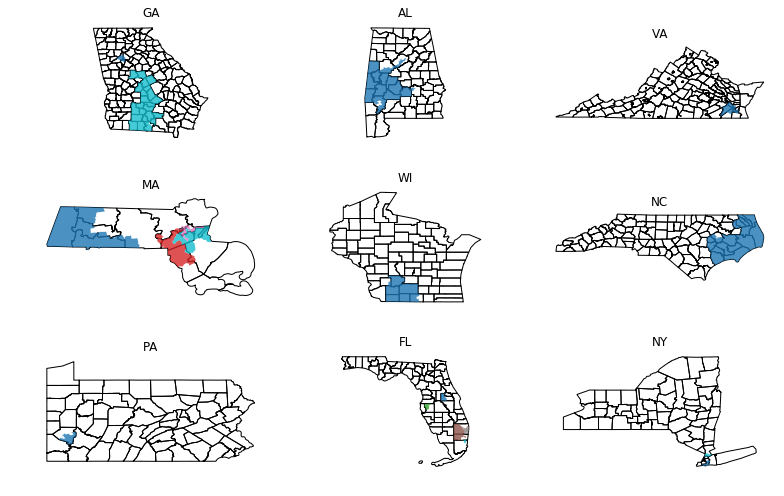

In [44]:
st_list = mm['STUSPS'].unique()
fig, axes = plt.subplots(len(st_list)//3, 3, figsize=(11,7))
for i, st in enumerate(st_list):
    ax = axes[i//3][i%3]
    counties[counties['STUSPS']==st].plot(edgecolor='k', facecolor=(0,0,0,0), ax=ax)
    mm[mm['STUSPS']==st].plot(column='CD116FP', alpha=0.8, ax = ax)
    ax.set_title(st)
    ax.set_axis_off()
fig.tight_layout()

In [45]:
new_votes = defaultdict(lambda: defaultdict(int))

for idx in range(len(mm)):
    cc = counties[counties['STUSPS'].isin(mm.iloc[[idx]]['STUSPS'])].sort_values('GEOID')
    inters = gpd.overlay(cc, mm.iloc[[idx]], how='intersection').sort_values('GEOID_1')
    
    fraction = inters.geometry.area.values / mm.iloc[[idx]].area.values

    for j, geoid in enumerate(inters['GEOID_1']):
        fr = fraction[j]
        for p in ['green','libertarian','republican','democrat','independent']:
            new_votes[geoid][p] = int(mm.iloc[[idx]][p].values[0]*fr)

When a district is split between multiple counties, I am assigning votes to each county according to the fractional area (with respect to the district area). So for example if a congressional district encompasses 3 counties A,B,C, particularly two fully enclosed and one with only 1/3 of the area (here let's assume all have equal size), the votes V will be shared as follow:

$
V_i=  \frac{area(i)}{area(district)}V, \qquad \implies \qquad V_A = V_B = \frac{3}{7}V, \quad V_C = \frac17 V
$

Now, this is a crude approximation. A district might be focused on a small densely populated area of one county and then extend much further out in the suburbs in another. My treatment gives the votes to the larger county, and might mess up the balance of votes in that area.

For example, see below what happens to [NY 16th district](https://en.wikipedia.org/wiki/New_York%27s_16th_congressional_district), which includes northern Bronx and the southern half of Westchester County, including the suburban cities of Mount Vernon, Yonkers, and Rye. the 182,000 votes get split mostly into Westchester county instead of Bronx (162,000 vs 20,000), but the [official results](https://www.elections.ny.gov/NYSBOE/elections/2018/general/2018Congress.pdf) are less lopsided (117,000 vs 65,000).


In [46]:
mm.iloc[[idx]]

,STATEFP,CD116FP,GEOID,NAMELSAD,geometry,STUSPS,FIPS,green,libertarian,republican,democrat,independent,total,margin
413,36,16,3616,Congressional District 16,"POLYGON ((-73.933652 40.882463, -73.9317289999...",NY,NY16,0,0,0,182044,0,182044,0.999995


In [47]:
cc[cc['GEOID'].isin(inters['GEOID_1'])]

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS,POPESTIMATE2017
3072,36,005,36005,Bronx,Bronx County,"POLYGON ((-73.933652 40.882463, -73.9317289999...",NY,1471160
1101,36,119,36119,Westchester,Westchester County,"POLYGON ((-73.90928099999999 41.164395, -73.91...",NY,980244


In [48]:
print(new_votes['36005'])
print(new_votes['36119'])

defaultdict(<type 'int'>, {'libertarian': 0, 'independent': 0, 'republican': 0, 'green': 0, 'democrat': 20012})
defaultdict(<type 'int'>, {'libertarian': 0, 'independent': 0, 'republican': 0, 'green': 0, 'democrat': 162031})


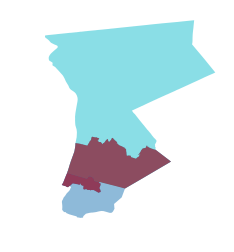

In [49]:
mm.iloc[[idx]].plot()
cc[cc['GEOID'].isin(inters['GEOID_1'])].plot(ax=plt.gca(), cmap='tab10', alpha=0.5)
inters.plot(ax=plt.gca(), color='r', alpha=0.5)
plt.gca().set_axis_off()

We are now done with fixing the dataset. For the rest, we take the county-by-county totals that the NYT gives

In [50]:
# make a dictionary of dictionaries, each county having vote tallies by party
counties_votes = defaultdict(lambda: defaultdict(int))
other_races = set()

for row in data['races']:
    if row['office'] != 'U.S. House':
        other_races.add(row['office'])
        continue
    if row['precincts_reporting']!=row['precincts_total']:
        print(row['state_id'], row['seat_name'], row['precincts_reporting'], row['precincts_total'])
    candidate_keys_parties = []
    for c in row['candidates']:
        candidate_keys_parties.append([c['candidate_key'], c['party_id']])

    for county in row['counties']:
        fips = county['fips']
        # check: multiple candidates for orange county
        # if fips =='06059':
        #     print(candidate_keys_parties)
        
        # counties_votes[fips]['total'] += county['votes']
        # if multiple independent candidates, this will add them together
        for c, p in candidate_keys_parties:
            counties_votes[fips][p] += county['results'][c]


In [51]:
len(counties_votes.keys())

3054

In [52]:
counties_votes.keys()[-1], counties_votes[counties_votes.keys()[-1]]

('31175', defaultdict(int, {'democrat': 315, 'republican': 1475}))

In [53]:
df = pd.DataFrame.from_dict(counties_votes, orient='index', dtype=int).fillna(value=0).astype(int)
df.head()

,libertarian,independent,republican,democrat,constitution,no-party-affiliation,other,green,independent-american,working-class,...,reform,american-party,united-utah,independence,working-families,conservative,nonpartisan,liberty-union,pacific-green,womens-equality
01001,0,0,13400,6221,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01003,0,0,59992,17779,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01005,0,0,4191,4162,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01007,0,0,5299,1559,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01009,0,0,17420,1957,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df.sum().sort_values()

nonpartisan                 1351
womens-equality             2988
liberty-union               3924
other                       4850
mountain                    6277
working-families            9348
independence               12741
american-party             15011
independent-american       15801
constitution               19722
conservative               20921
pacific-green              25879
us-taxpayers               27233
united-utah                36177
working-class              53102
reform                     53540
no-party-affiliation       95086
green                     215966
independent               697306
libertarian               735538
republican              50595506
democrat                57912174
dtype: int64

In [55]:
keep_columns = [u'green', u'libertarian', u'republican', u'democrat']

indep = sum([df[c] for c in df.columns if c not in keep_columns])
df = df[keep_columns]
df['independent'] = indep
df.head()

,green,libertarian,republican,democrat,independent
01001,0,0,13400,6221,0
01003,0,0,59992,17779,0
01005,0,0,4191,4162,0
01007,0,0,5299,1559,0
01009,0,0,17420,1957,0


In [56]:
df.sum().sort_values()

green            215966
libertarian      735538
independent     1101257
republican     50595506
democrat       57912174
dtype: int64

In [57]:
# put uncontested races data in a dataframe to be merged
df1 = pd.DataFrame.from_dict(new_votes, orient='index', dtype=int).fillna(value=0).astype(int)
df1.head()

,libertarian,independent,republican,green,democrat
01001,0,0,0,0,0
01007,0,0,0,0,0
01023,0,0,0,0,16490
01025,0,0,0,0,18815
01047,0,0,0,0,17855


In [58]:
df = df.add(df1, fill_value=0)
df['total'] = df.T.sum()
df['FIPS'] = df.index
df.head()

,democrat,green,independent,libertarian,republican,total,FIPS
01001,6221.0,0.0,0.0,0.0,13400.0,19621.0,01001
01003,17779.0,0.0,0.0,0.0,59992.0,77771.0,01003
01005,4162.0,0.0,0.0,0.0,4191.0,8353.0,01005
01007,1559.0,0.0,0.0,0.0,5299.0,6858.0,01007
01009,1957.0,0.0,0.0,0.0,17420.0,19377.0,01009


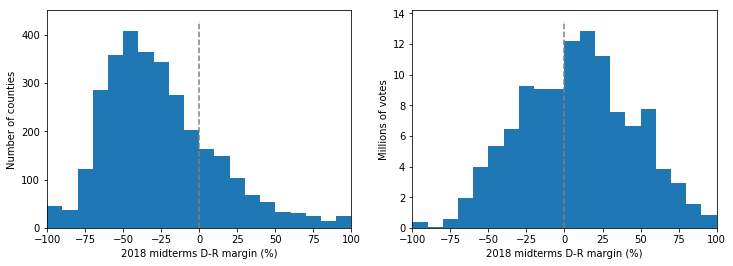

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
(100*(df['democrat'] - df['republican'])/df['total']).hist(bins=np.linspace(-100,100,21), ax=ax1)
(100*(df['democrat'] - df['republican'])/df['total']).hist(bins=np.linspace(-100,100,21), weights=df['total']/10**6, ax=ax2)
ax1.set(ylabel='Number of counties')
ax2.set(ylabel = 'Millions of votes')
for ax in (ax1, ax2):
    ax.grid()
    ax.set(xlabel='2018 midterms D-R margin (%)', xlim=(-100,100))
    ax.vlines(0,0,ax.get_ylim()[1], colors='gray',linestyles='--')

It doesn't make sense to fix Alaska. One congressional district for the whole state. Spreading the votes according to the local population in each county would just make the whole state one color, which would paint the wrong picture because there is some variation. The [Alaska elections page](www.elections.alaska.gov/results/18GENR/Map/) shows results by Alaska house districts, but those are not the same as counties and it would be a lot of work to remap those.

### plot county level data

In [60]:
len(counties_votes), len(new_votes), len(df.index)

(3054, 116, 3112)

In [61]:
res = counties[counties['GEOID'].isin(df.index)]
res.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS,POPESTIMATE2017
0,31,039,31039,Cuming,Cuming County,"POLYGON ((-97.019516 42.004097, -97.019519 42....",NE,9042
1,53,069,53069,Wahkiakum,Wahkiakum County,"POLYGON ((-123.436394 46.238197, -123.447592 4...",WA,4264
2,35,011,35011,De Baca,De Baca County,"POLYGON ((-104.567387 33.997566, -104.567717 3...",NM,1829
3,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91059899999999 40.958407, -96.91...",NE,314358
4,31,129,31129,Nuckolls,Nuckolls County,"POLYGON ((-98.27366699999999 40.089399, -98.27...",NE,4275


In [62]:
us_df[us_df['STUSPS'].isin(['HI','AK'])][['NAME','GEOID']]

,NAME,GEOID
49,Hawaii,15
50,Alaska,02


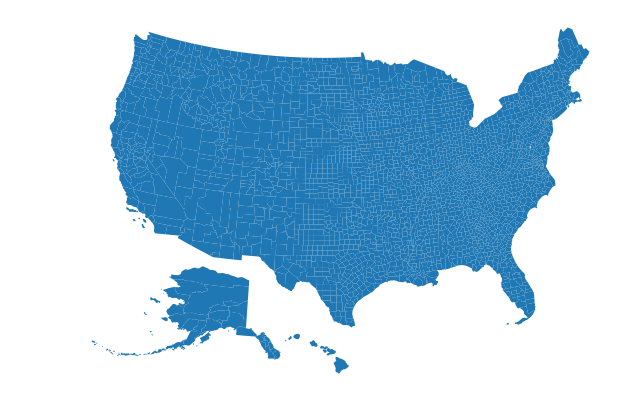

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_axis_off()
rest = res[~res['STATEFP'].isin(us_df[us_df['STUSPS'].isin(['HI','AK'])]['GEOID'])]
# rest.plot(ax=ax)

# move hawaii
temp = res[res['STATEFP'].isin(us_df[us_df['STUSPS'].isin(['HI'])]['GEOID'])].copy()
temp.geometry = temp.geometry.apply(lambda x: shapely.ops.transform(filter_HI, x))
temp.geometry = temp.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=57, yoff=3))
# temp.plot(ax=ax)
tempHI = temp.copy()

# move alaska
temp = counties[(counties['STATEFP']=='02')].copy()
temp.geometry = temp.geometry.apply(lambda x: shapely.ops.transform(mod_long, x))
temp.geometry = temp.geometry.apply(lambda x: shapely.affinity.affine_transform(x, matrix=[0.3,0,0,0.44,-65,-1]))
# temp.plot(ax=ax)

results = gpd.GeoDataFrame(pd.concat([rest, tempHI, temp], ignore_index=True), crs=rest.crs)
results.to_crs(epsg=2163).plot(ax=ax);

In [64]:
missing = counties[~counties['GEOID'].isin(df['FIPS'].values)]
missing.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS,POPESTIMATE2017
74,02,130,02130,Ketchikan Gateway,Ketchikan Gateway Borough,"POLYGON ((-132.268044 55.633798, -132.205916 5...",AK,13856
239,02,188,02188,Northwest Arctic,Northwest Arctic Borough,"POLYGON ((-165.591987 68.034728, -165.571648 6...",AK,7684
311,02,220,02220,Sitka,Sitka City and Borough,"POLYGON ((-136.454427 57.830676, -136.442669 5...",AK,8689
505,02,290,02290,Yukon-Koyukuk,Yukon-Koyukuk Census Area,"POLYGON ((-149.32543 67.999999, -149.1459 68, ...",AK,5365
612,11,001,11001,District of Columbia,District of Columbia,POLYGON ((-77.11975099999999 38.93434999999999...,DC,693972


In [65]:
missing[['STATEFP','STUSPS']].fillna('NaN').groupby('STUSPS', as_index=False).count().sort_values('STATEFP')

,STUSPS,STATEFP
1,DC,1
2,HI,1
0,AK,29


Makes sense: we don't have county-level data for Alaska, and both DC and Puerto Rico don't have representatives.

In [95]:
# missing = missing[~missing['STUSPS'].fillna('NaN').isin(['PR','DC','AK','HI','NaN'])]
# results.plot(figsize=(10,5))
# missing[~(missing['STUSPS']=='HI')].plot(facecolor='m', ax=plt.gca());
# plt.gca().set_axis_off()

In [66]:
dd = pd.merge(results, us_df[['GEOID','STUSPS']], left_on='STATEFP', right_on='GEOID', how='left', suffixes={'','_y'})
dd = pd.merge(dd, df, left_on='GEOID', right_on='FIPS', how='right', suffixes={'','_y'})
dd.drop(columns=['GEOID_y','STUSPS_y','FIPS'], inplace=True)
dd['margin'] = (dd['democrat'] - dd['republican'])/dd['total']
dd.head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,STUSPS,POPESTIMATE2017,democrat,green,independent,libertarian,republican,total,margin
0,31,039,31039,Cuming,Cuming County,"POLYGON ((-97.019516 42.004097, -97.019519 42....",NE,9042.0,552.0,0.0,0.0,0.0,2797.0,3349.0,-0.670349
1,53,069,53069,Wahkiakum,Wahkiakum County,"POLYGON ((-123.436394 46.238197, -123.447592 4...",WA,4264.0,1022.0,0.0,0.0,0.0,1416.0,2438.0,-0.161608
2,35,011,35011,De Baca,De Baca County,"POLYGON ((-104.567387 33.997566, -104.567717 3...",NM,1829.0,292.0,0.0,0.0,0.0,500.0,792.0,-0.262626
3,31,109,31109,Lancaster,Lancaster County,"POLYGON ((-96.91059899999999 40.958407, -96.91...",NE,314358.0,59143.0,0.0,0.0,0.0,57568.0,116711.0,0.013495
4,31,129,31129,Nuckolls,Nuckolls County,"POLYGON ((-98.27366699999999 40.089399, -98.27...",NE,4275.0,319.0,0.0,0.0,0.0,1436.0,1755.0,-0.636467


In [150]:
# check by hand that the cmap argument in pd.plot works as intended
# dd.loc[[2078]].plot(facecolor=col_alpha_rescale(-0.26,0), legend=True, vmin=-1, vmax=1)
# dd.loc[[2078]].plot(column='margin', cmap=cmap, legend=True, vmin=-1, vmax=1)
# dd[dd['STUSPS']=='AZ']

In [67]:
dd.to_crs(epsg=2163).plot(column='margin', cmap=cmap, legend=True, figsize=(10,5), vmin=-1, vmax=1)
plt.gca().set_axis_off()

AttributeError: 'float' object has no attribute 'is_empty'

In [ ]:
dd.to_crs(epsg=2163).plot(column='margin', cmap=cmap, figsize=(12,7.5), vmin=-1, vmax=1)
# missing[~(missing['STUSPS']=='HI')].to_crs(epsg=2163).plot(facecolor='g', ax=plt.gca())
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='w', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
func_add_legend(plt.gcf(), left=0.95);
plt.savefig('figs/midterms18_counties.png', bbox_inches='tight')

## save combined GeoJSON files

Given that it is not publicly available, I thought it could be useful to share the 2018 combined dataset (county boundaries with associated votes). Because my estimate of how the uncontested races votes would be split into counties was somewhat crude, I made two versions of the GeoJSON file, `2018_midterms_votes.geojson` and `2018_midterms_votes_no_fill.geojson`.

In [304]:
def make_geojson(my_fill=True):
    """
    Creates GeoPandas dataframe from counties boundaries, population, state info.
    Adds to it vote counts from the dictionary counties_votes, including if my_fill==True,
    crude estimates from uncontested races from new_votes.
    Returns combined dataframe.
    """
    # load counties boundaries, drop useless columns, add state names from state dataset, add population county
    counties = gpd.GeoDataFrame.from_file(os.path.join(os.path.pardir, 'input',"tl_2017_us_county.dbf"))
    counties.drop(columns = [ u'COUNTYNS', u'CLASSFP', u'MTFCC', u'CSAFP', u'CBSAFP', u'METDIVFP', u'FUNCSTAT', u'LSAD',
                                         u'ALAND', u'AWATER', u'INTPTLAT', u'INTPTLON'], inplace=True)

    counties = pd.merge(counties, us_df[['GEOID','STUSPS']], left_on='STATEFP', right_on='GEOID', how='left', suffixes=['','_y'])
    counties.drop(columns=['GEOID_y'], inplace=True)

    co_pop = pd.read_csv(os.path.join(os.path.pardir, 'input',"co-est2017-alldata.csv"))
    co_pop = co_pop[co_pop['SUMLEV']==50] # only counties, drop states (which have SUMLEV=40)
    co_pop = co_pop[[u'STATE', u'COUNTY', u'STNAME', u'CTYNAME', u'POPESTIMATE2017']]
    co_pop['STATE'] = pd.Series(["{:02d}".format(int(val)) for val in co_pop['STATE']], index = co_pop.index)
    co_pop['COUNTY'] = pd.Series(["{:03d}".format(int(val)) for val in co_pop['COUNTY']], index = co_pop.index)
    co_pop['GEOID'] = co_pop['STATE']+co_pop['COUNTY']

    counties = pd.merge(counties, co_pop[['POPESTIMATE2017', 'GEOID']], on = 'GEOID')

    # put votes into a dataframe
    df = pd.DataFrame.from_dict(counties_votes, orient='index', dtype=int).fillna(value=0).astype(int)
    keep_columns = [u'green', u'libertarian', u'republican', u'democrat']
    indep = sum([df[c] for c in df.columns if c not in keep_columns])
    df = df[keep_columns]
    df['independent'] = indep
    
    if my_fill:
        # put uncontested races data in a dataframe to be merged
        df1 = pd.DataFrame.from_dict(new_votes, orient='index', dtype=int).fillna(value=0).astype(int)
        df = df.add(df1, fill_value=0)
    
    df['FIPS'] = df.index

    
    # merge counties with votes, reorder columns
    dd = pd.merge(counties, us_df[['GEOID','STUSPS']], left_on='STATEFP', right_on='GEOID', how='left', suffixes={'','_y'})
    dd = pd.merge(dd, df, left_on='GEOID', right_on='FIPS', how='inner', suffixes={'','_y'})
    dd.drop(columns=['GEOID_y','STUSPS_y','FIPS'], inplace=True)    
    dd = dd[dd.columns.values[[6,0,1,2,3,4,7,10,11,9,8,12,5]]]
    
    return dd

In [306]:
dd = make_geojson()

In [307]:
with open('2018_midterms_votes.geojson', 'w') as f:
    f.write(dd.to_json())

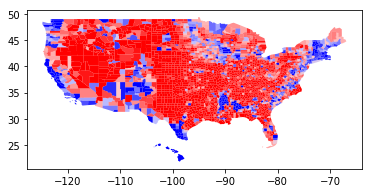

In [308]:
dd = gpd.read_file('2018_midterms_votes.geojson')
dd = dd[dd.columns[[3,12,6,5,2,11,9,1,7,8,4,10,13]]]

dd['total'] = dd.loc[:, 'independent':'republican'].T.sum()
dd['margin'] = (dd['democrat'] - dd['republican'])/dd['total']

dd.loc[dd['STUSPS']=='HI','geometry'] = dd.loc[dd['STUSPS']=='HI','geometry'].apply(lambda x: shapely.ops.transform(filter_HI, x)).apply(lambda x: shapely.affinity.translate(x, xoff=57, yoff=3))
dd.plot(column='margin', cmap=cmap, vmin=-1, vmax=1)

In [309]:
dd = make_geojson(my_fill = False)

In [310]:
with open('2018_midterms_votes_no_fill.geojson', 'w') as f:
    f.write(dd.to_json())

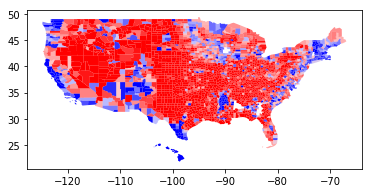

In [311]:
dd = gpd.read_file('2018_midterms_votes_no_fill.geojson')
dd = dd[dd.columns[[3,12,6,5,2,11,9,1,7,8,4,10,13]]]

dd['total'] = dd.loc[:, 'independent':'republican'].T.sum()
dd['margin'] = (dd['democrat'] - dd['republican'])/dd['total']

dd.loc[dd['STUSPS']=='HI','geometry'] = dd.loc[dd['STUSPS']=='HI','geometry'].apply(lambda x: shapely.ops.transform(filter_HI, x)).apply(lambda x: shapely.affinity.translate(x, xoff=57, yoff=3))
dd.plot(column='margin', cmap=cmap, vmin=-1, vmax=1)

## election results by state
Here I gather votes by state and look at trends with respect to the 2016 election. In particular, I compare the 2016 state-level presidential votes, so the comparison is slightly apple to oranges (but not too crazy).

In [75]:
st_df1 = us_df.copy()
st_df1.set_index('STATEFP', inplace=True)

In [76]:
st_df = dd.groupby(['STUSPS','STATEFP']).sum()
st_df.reset_index(inplace=True)
st_df.set_index('STATEFP', inplace=True)
st_df = st_df.append(df[df['FIPS']=='02000'].drop(columns='FIPS'), sort=True)
st_df['margin'] = (st_df['democrat'] - st_df['republican'])/st_df['total']
st_df.rename(index={'02000':'02'}, inplace=True)
st_df.loc['02','POPESTIMATE2017'] = counties.groupby(['STUSPS']).sum().loc['AK'].values[0]
st_df.loc['02','STUSPS'] = 'AK'
st_df.loc['02','margin'] = (st_df.loc['02','independent'] - st_df.loc['02','republican'])/st_df.loc['02','total']

# st_df.reset_index(inplace=True)
st_df.tail()

,POPESTIMATE2017,STUSPS,democrat,green,independent,libertarian,margin,republican,total
53,7405743.0,WA,1888593.0,0.0,0.0,84646.0,0.277927,1048712.0,3021951.0
55,5795483.0,WI,1256988.0,0.0,21592.0,0.0,0.034274,1172964.0,2451544.0
54,1815857.0,WV,234568.0,0.0,6277.0,0.0,-0.177473,337146.0,577991.0
56,579315.0,WY,59903.0,0.0,6070.0,6918.0,-0.338853,127963.0,200854.0
02,739795.0,AK,0.0,0.0,131199.0,0.0,-0.066126,149779.0,280978.0


In [77]:
st_df['geometry'] = st_df1.geometry
st_df = gpd.GeoDataFrame(st_df, geometry='geometry')
st_df.crs = us_df.crs

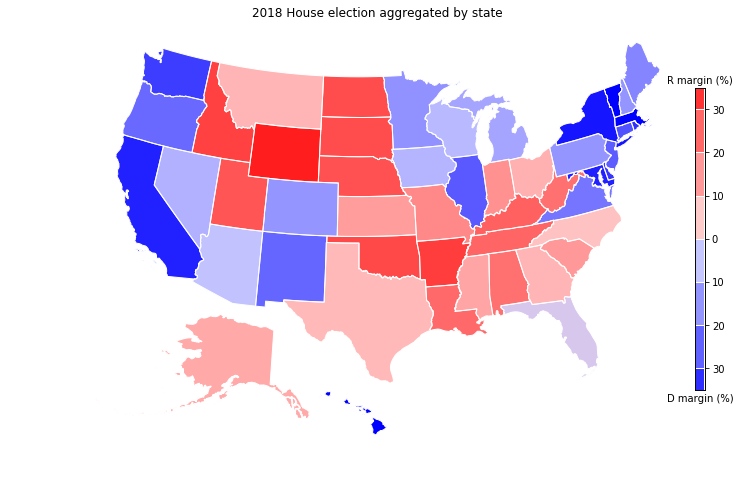

In [78]:
st_df.to_crs(epsg=2163).plot(column='margin', cmap=cmap, figsize=(9,6), vmin=-1, vmax=1);
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='w', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
plt.title('2018 House election aggregated by state')
func_add_legend(plt.gcf(), left=0.99)
plt.savefig('figs/midterms18_states.png', bbox_inches='tight')

### comparison to 2016 elections

In [79]:
res16 = [[u'AL', '-0.280'], [u'AK', '-0.154'], [u'AZ', '-0.036'], [u'AR', '-0.276'], [u'CA', '0.305'], [u'CO', '0.050'], [u'CT', '0.137'], [u'DE', '0.114'], [u'DC', '0.886'], [u'FL', '-0.012'], [u'GA', '-0.051'], [u'HI', '0.325'], [u'ID', '-0.345'], [u'IL', '0.171'], [u'IN', '-0.192'], [u'IA', '-0.097'], [u'KS', '-0.207'], [u'KY', '-0.302'], [u'LA', '-0.198'], [u'ME', '0.030'], [u'MD', '0.268'], [u'MA', '0.276'], [u'MI', '-0.002'], [u'MN', '0.016'], [u'MS', '-0.179'], [u'MO', '-0.188'], [u'MT', '-0.206'], [u'NE', '-0.255'], [u'NV', '0.025'], [u'NH', '0.004'], [u'NJ', '0.142'], [u'NM', '0.083'], [u'NY', '0.227'], [u'NC', '-0.037'], [u'ND', '-0.366'], [u'OH', '-0.082'], [u'OK', '-0.364'], [u'OR', '0.114'], [u'PA', '-0.007'], [u'RI', '0.159'], [u'SC', '-0.145'], [u'SD', '-0.301'], [u'TN', '-0.263'], [u'TX', '-0.091'], [u'UT', '-0.234'], [u'VT', '0.286'], [u'VA', '0.054'], [u'WA', '0.164'], [u'WV', '-0.424'], [u'WI', '-0.008'], [u'WY', '-0.481']]

In [80]:
results16 = {}
for st, marg in res16:
    results16[st] = float(marg)

In [81]:
sdf16 = pd.DataFrame.from_dict(results16, orient = 'index', columns=['margin16'])
sdf16['STUSPS'] = sdf16.index
sdf16.head()

,margin16,STUSPS
WA,0.164,WA
DE,0.114,DE
DC,0.886,DC
WI,-0.008,WI
WV,-0.424,WV


In [82]:
st_df = pd.merge(st_df, sdf16, on = 'STUSPS')

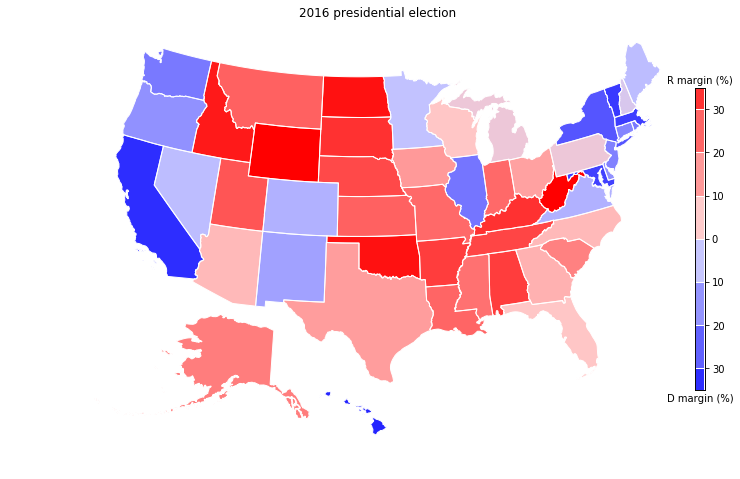

In [83]:
st_df.to_crs(epsg=2163).plot(column='margin16', cmap=cmap, figsize=(9,6), vmin=-1, vmax=1);
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='w', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
plt.title('2016 presidential election')
func_add_legend(plt.gcf(), left=0.99)
plt.savefig('figs/midterms18_states_16.png', bbox_inches='tight')

In [84]:
st_df['col16'] = st_df['margin16'].apply(lambda x: col_alpha_rescale(x,0))
st_df['col18'] = st_df['margin'].apply(lambda x: col_alpha_rescale(x,0))


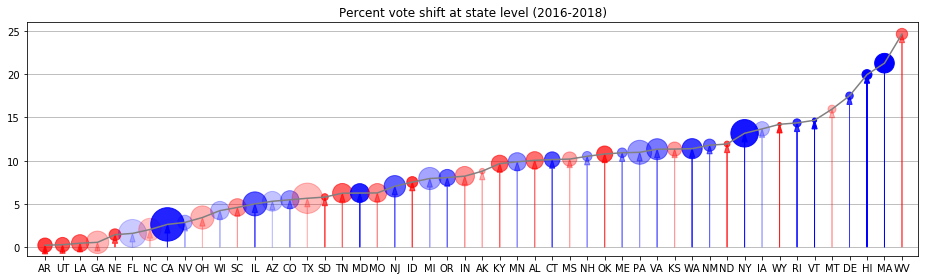

In [85]:
xx = (st_df[['margin','margin16', 'POPESTIMATE2017', 'STUSPS','col18']].values)
m18, m16, pop, states, cols = np.array(sorted(xx, key=lambda x: x[0]-x[1])).T
y=m18-m16

marksizes = lambda tot: np.sqrt(tot)/5-140

fig, ax = plt.subplots(1,1,figsize=(13,4))
plt.plot(100*y, c='0.5')
plt.scatter(range(len(y)), 100*y, s=marksizes(pop.astype(float)), c=cols)
for ix in range(len(y)):
    ax.arrow(ix, 0, 0, 100*y[ix], color=cols[ix], head_width=0.3, head_length=1, length_includes_head=True)

plt.xticks(range(len(states)),states)#,rotation=90,ha='center');
ax.margins(0.01,0.01)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set( ylim= (-1,26), title=('Percent vote shift at state level (2016-2018)'));
fig.tight_layout()

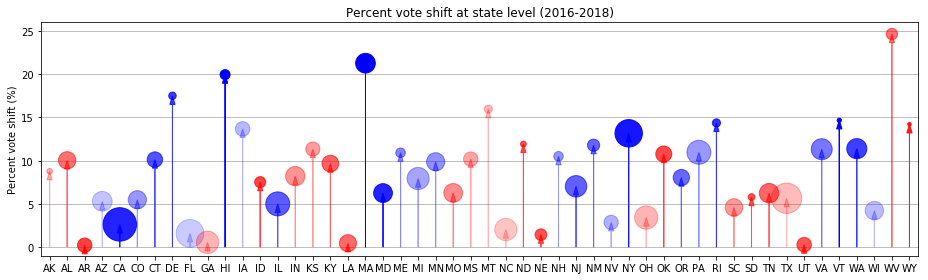

In [86]:
xx = (st_df[['margin','margin16', 'POPESTIMATE2017', 'STUSPS','col18']].values)
m18, m16, pop, states, cols = np.array(sorted(xx, key=lambda x: x[-2])).T
y=m18-m16

marksizes = lambda tot: np.sqrt(tot)/5-140

fig, ax = plt.subplots(1,1,figsize=(13,4))
plt.scatter(range(len(y)), 100*y, s=marksizes(pop.astype(float)), c=cols)
for ix in range(len(y)):
    ax.arrow(ix, 0, 0, 100*y[ix], color=cols[ix], head_width=0.3, head_length=1, length_includes_head=True)

plt.xticks(range(len(states)),states)#,rotation=90,ha='center');
ax.margins(0.01,0.01)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set( ylim= (-1,26), title=('Percent vote shift at state level (2016-2018)'), ylabel='Percent vote shift (%)')
fig.tight_layout()
plt.savefig('figs/midterms18_shift.png', bbox_inches='tight')

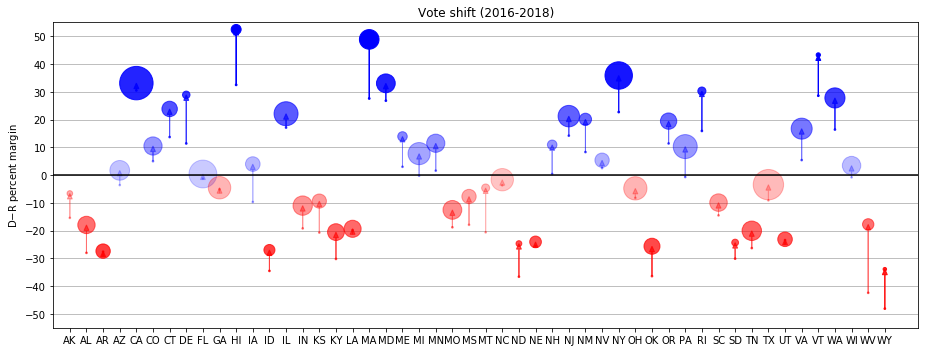

In [87]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
m18, m16, pop, states, cols = np.array(sorted(xx, key=lambda x: x[-2])).T

plt.plot((-1,len(m18)+1), (0,0), 'k')
plt.scatter(range(len(m18)), 100*m18, s=marksizes(pop.astype(float)), c=cols)
plt.scatter(range(len(m16)), 100*m16, s=3, c=cols)

for ix in range(len(m16)):
    ax.arrow(ix, 100*m16[ix], 0, 100*(m18[ix]-m16[ix]), color=cols[ix], head_width=0.3, head_length=2, length_includes_head=True)

plt.xticks(range(len(states)),states);
ax.margins(0.01,0.01)
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set(ylim= (-55,55), yticks=range(-50,51,10), xlim=(-1,len(m18)+1), title='Vote shift (2016-2018)', 
       ylabel='D$-$R percent margin')
fig.tight_layout()
plt.savefig('figs/midterms18_shift_margin.png', bbox_inches='tight')

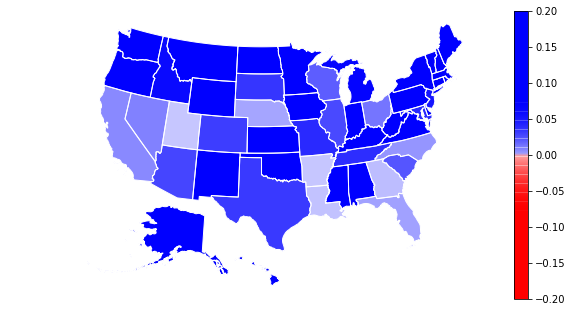

In [88]:
st_df['change16_18'] = st_df['margin'] - st_df['margin16']
st_df.to_crs(epsg=2163).plot(column='change16_18', cmap=cmap, figsize=(9,4), vmin=-0.2, vmax=0.2, legend=True);
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='w', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
# func_add_legend(plt.gcf(), left=0.99);

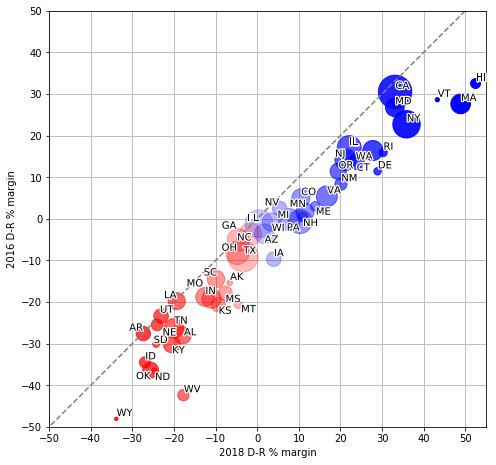

In [116]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

m18, m16, pop, states, cols = np.array(sorted(xx, key=lambda x: x[0])).T

fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot( [-55,55], [-55,55], '--', c='0.5')
plt.scatter(100*m18, 100*m16, s=marksizes(pop.astype(float)), c=cols)
ax.set(aspect=1)
ax.grid()
ax.set( xlim = (-50,55), ylim=(-50,50), xticks=range(-50,51,10), yticks=range(-50,51,10), xlabel='2018 D-R % margin', ylabel='2016 D-R % margin')

ax.set_axisbelow(True)
ax.margins(0.01,0.01)
fig.tight_layout()

text = [ ax.text(100*xy[0], 100*xy[1], states[i] )  for i, xy in enumerate(zip(m18,m16))]
for txt in text: txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
adjust_text(text);

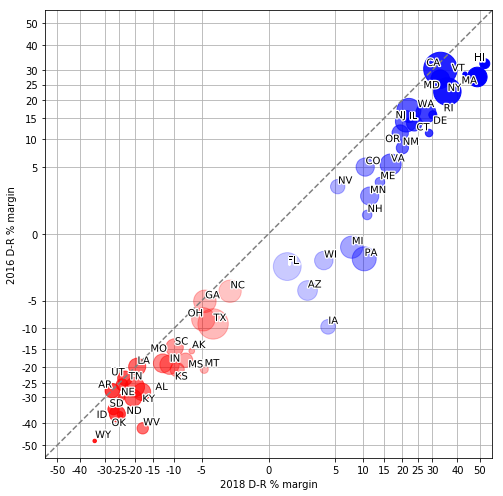

In [117]:
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

m18, m16, pop, states, cols = np.array(sorted(xx, key=lambda x: x[0])).T

m18 = np.sign(m18)* np.sqrt(np.abs(100*m18.astype(float)))
m16 = np.sign(m16)* np.sqrt(np.abs(100*m16.astype(float)))

fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot( [-65,65], [-65,65], '--', c='0.5')
plt.scatter(m18, m16, s=marksizes(pop.astype(float)), c=cols)
ax.set(aspect=1)
ax.grid()
tt = sorted(range(-25,31,10)+range(-50,51,10))
tt1 = np.sign(tt)* np.sqrt(np.abs(tt))
ax.set( xlim = (-7.5,7.5), ylim=(-7.5,7.5), xticks=tt1, xticklabels = tt, yticks=tt1, yticklabels = tt,
       xlabel='2018 D-R % margin', ylabel='2016 D-R % margin')

ax.set_axisbelow(True)
ax.margins(0.01,0.01)
fig.tight_layout()

text = [ ax.text(xy[0], xy[1], states[i] )  for i, xy in enumerate(zip(m18,m16))]
for txt in text: txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
adjust_text(text);

In [170]:
sum([ec_dic[state] for state in ['New Hampshire', 'Pennsylvania', 'Michigan', 'Wisconsin', 'Iowa', 'Arizona']])

67

## senate races

Same as above: extract senate races votes from JSON and plot them. I will mark Bernie Sanders and Angus King as Democrats instead of Independents because for all purposes they are (and it makes it simpler to process the data).

In [89]:
senate_votes = defaultdict(lambda: defaultdict(int))

for row in data['races']:
    if row['office'] != 'U.S. Senate':
        continue
    
    state = row['state_id']
    #if state == 'CA':     print(data['races'].index(row))
    for c in row['candidates']:
        senate_votes[state][c['party_id']] += c['votes']

In [90]:
senate_votes['VT']

defaultdict(int,
            {'independent': 196344,
             'liberty-union': 1171,
             'republican': 74815})

In [91]:
se_df = pd.DataFrame.from_dict(senate_votes, orient='index').fillna(value=0).astype(int)
se_df.head()

,republican,democrat,libertarian,green,independent,no-party-designation,independent-american,liberty-union,constitution,us-taxpayers,natural-law,reform
AZ,1135200,1191100,0,57442,0,0,0,0,0,0,0,0
CA,0,11113364,0,0,0,0,0,0,0,0,0,0
CT,545717,825579,8838,6618,0,0,0,0,0,0,0,0
DE,137127,217385,3910,4170,0,0,0,0,0,0,0,0
FL,4099505,4089472,0,0,0,0,0,0,0,0,0,0


In [92]:
keep_columns = [u'green', u'libertarian', u'republican', u'democrat']

indep = sum([se_df[c] for c in se_df.columns if c not in keep_columns])
se_df = se_df[keep_columns]
se_df['independent'] = indep

se_df['STUSPS'] = se_df.index
se_df['total'] = se_df[[u'independent', u'green', u'libertarian', u'republican', u'democrat']].T.sum()
se_df['margin'] = (se_df['democrat'] - se_df['republican'])/(se_df['total']+1)
# se_df.loc['CA','margin'] = (data['races'][31]['candidates'][0]['votes']-data['races'][31]['candidates'][1]['votes'])/(se_df.loc['CA','total']+1)
se_df.loc['VT','margin'] = (se_df.loc['VT','independent'] - se_df.loc['VT','republican'])/(se_df.loc['VT','total']+1)
se_df.loc['ME','margin'] = (se_df.loc['ME','independent'] - se_df.loc['ME','republican'])/(se_df.loc['ME','total']+1)
se_df.head()

,green,libertarian,republican,democrat,independent,STUSPS,total,margin
AZ,57442,0,1135200,1191100,0,AZ,2383742,0.023451
CA,0,0,0,11113364,0,CA,11113364,1.000000
CT,6618,8838,545717,825579,0,CT,1386752,0.201811
DE,4170,3910,137127,217385,0,DE,362592,0.221345
FL,0,0,4099505,4089472,0,FL,8188977,-0.001225


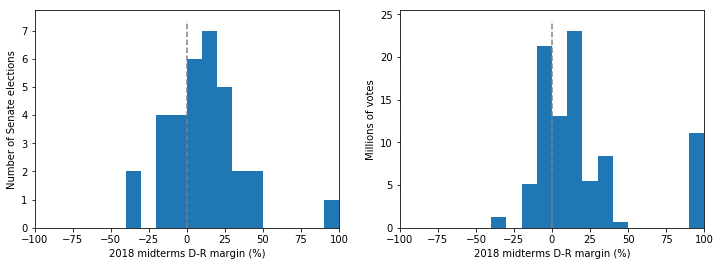

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
(100*se_df['margin']).hist(bins=np.linspace(-100,100,21), ax=ax1)
(100*se_df['margin']).hist(bins=np.linspace(-100,100,21), weights= se_df['total']/10**6, ax=ax2)
ax1.set(ylabel='Number of Senate elections')
ax2.set(ylabel = 'Millions of votes')
for ax in (ax1, ax2):
    ax.grid()
    ax.set(xlabel='2018 midterms D-R margin (%)', xlim=(-100,100))
    ax.vlines(0,0,ax.get_ylim()[1], colors='gray',linestyles='--')

In [94]:
st_df = pd.merge(st_df, se_df[['STUSPS','margin']], on = 'STUSPS', suffixes=['','_senate'], how='left')

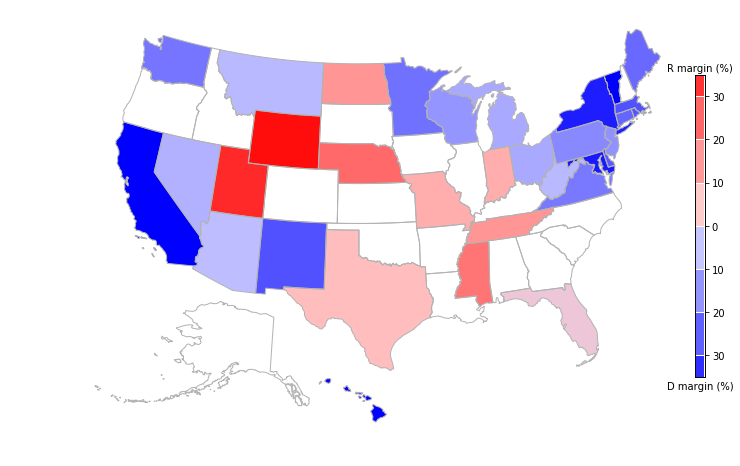

In [96]:
st_df.dropna().to_crs(epsg=2163).plot(column='margin_senate', cmap=cmap, figsize=(9,6), vmin=-1, vmax=1);
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='0.7', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
func_add_legend(plt.gcf(), left=0.99);

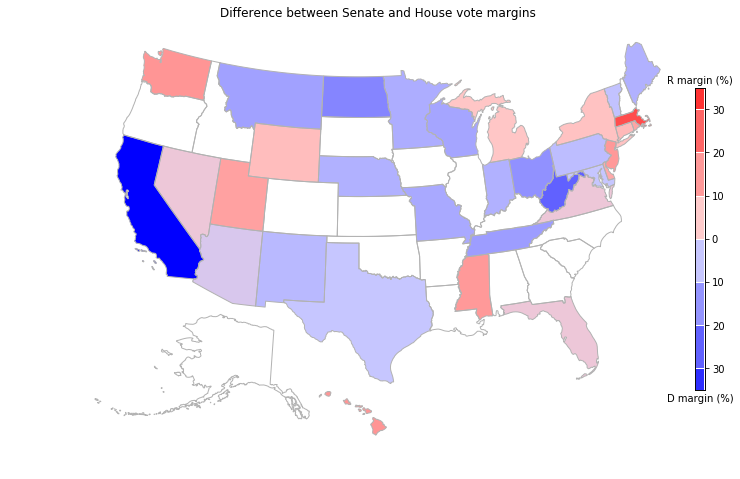

In [97]:
st_df['delta_house_senate'] = (st_df['margin_senate']-st_df['margin'])
st_df.dropna().to_crs(epsg=2163).plot(column='delta_house_senate', cmap=cmap, figsize=(9,6), vmin=-1, vmax=1);
us_df.to_crs(epsg=2163).plot(ax=plt.gca(), edgecolor='0.7', facecolor=(0,0,0,0))
plt.gca().set_axis_off()
plt.gcf().subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)
plt.title('Difference between Senate and House vote margins')
func_add_legend(plt.gcf(), left=0.99);

Notable trends:
- California had two democratic candidates to the Senate
- there is an incumbent effect in many states (most notable in West Virginia, Alabama).
- in many other states, the opposite: in Texas, Massachusets and Washington the eventual Senate winner got less votes than were cast for the same party in house races